# Sentiment classification of IMDB movie ratings

 ## Using EMBEDDINGS and LSTM

<img src="plan.png" height="500">

In [1]:
import keras.datasets.imdb as imdb
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pylab as plt

In [2]:
%%time

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

print(len(X_train), "Training sequences")
print(len(X_test), "Validation sequences")

25000 Training sequences
25000 Validation sequences
Wall time: 6.53 s


In [3]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 

In [4]:
def sequence2text(array):
    decoded = " ".join( [reverse_index.get(i-3 , "") for i in array] )
    return decoded[1:] #remove first space from join()

In [5]:
sequence2text(X_train[0])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly  was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little  that played the  of norman and paul they were just brilliant children are often left out of the  list i think because the stars that play them all grown up are such a big  for the whole film but these children are amazing and should be  for what they have done don't you think the whole story was so lovely 

In [6]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [7]:
sequence2text(X_train[0])

"                                                                                                                                                                                                                                                                                          this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly  was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little  that played the  of norma

In [8]:
embedding_layer = Embedding(input_dim= top_words,
                            output_dim = 100,
                            input_length= max_review_length)

In [9]:
# create the model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=100)

Epoch 1/5
250/250 [==============================] - 384s 2s/step - loss: 0.5596 - accuracy: 0.7029 - val_loss: 0.3673 - val_accuracy: 0.8535
Epoch 2/5
250/250 [==============================] - 394s 2s/step - loss: 0.3033 - accuracy: 0.8796 - val_loss: 0.3369 - val_accuracy: 0.8631
Epoch 3/5
250/250 [==============================] - 403s 2s/step - loss: 0.2451 - accuracy: 0.9039 - val_loss: 0.3227 - val_accuracy: 0.8712
Epoch 4/5
250/250 [==============================] - 405s 2s/step - loss: 0.2413 - accuracy: 0.9056 - val_loss: 0.3253 - val_accuracy: 0.8705
Epoch 5/5
250/250 [==============================] - 407s 2s/step - loss: 0.1737 - accuracy: 0.9374 - val_loss: 0.3265 - val_accuracy: 0.8694
Wall time: 33min 13s


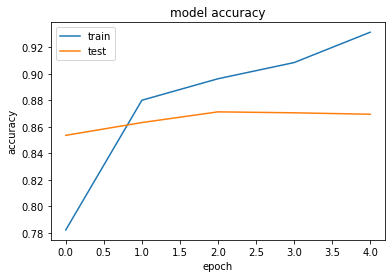

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
y_pred = model.predict(X_test)

In [13]:
k = 0
while True:
    i = np.random.randint(len(X_test))
    if k == 3 : break
    pred = np.round(y_pred[i][0])
    true = y_test[i]
    if pred != true:
        print("Predicted :",pred, " True class : ",true, " Certainty : ", np.abs(true - y_pred[i][0]) )
        print(sequence2text(X_test[i]))
        print()
        k += 1

Predicted : 1.0  True class :  0  Certainty :  0.7358654737472534
                                                                                                                                                                                                                                                                                                                                                                 awful br br despite the good performance of ed harris diane  and the strong budget the reason for the 3 stars the movie is by far the worst i saw about a  and the worst edition of a masterpiece of music i agree with some fictional stuff to  a  that otherwise couldn't be so charming this was done in  with best results but this b copy here is a flaw  had a strong personality but was a  artist here in this movie however he looks much more as mike  i wonder also whether despite his  he heard all the in the last scenes may be a  i prefer to listen to the  on a cd with some nice  

In [14]:
from sklearn.metrics import classification_report
target_names = ['Negative','Positive']
print(classification_report(y_test, np.round(y_pred), target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87     12500
    Positive       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## LSTM and pre-trained GLOVE embeddings

In [15]:
embeddings_index = {}
f = open('glove.6B.100d.txt','r',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [16]:
embedding_matrix = np.zeros((len(index) + 1, 100))
for word, i in index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i+3] = embedding_vector

In [17]:
embedding_layer = Embedding(input_dim= embedding_matrix.shape[0],
                            output_dim = embedding_matrix.shape[1],
                            input_length= max_review_length,
                            weights=[embedding_matrix],
                            trainable=False)

In [18]:
# create the model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          8858500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 8,939,001
Trainable params: 80,501
Non-trainable params: 8,858,500
_________________________________________________________________
None


In [19]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=100)

Epoch 1/5
250/250 [==============================] - 328s 1s/step - loss: 0.6550 - accuracy: 0.6088 - val_loss: 0.5031 - val_accuracy: 0.7624
Epoch 2/5
250/250 [==============================] - 323s 1s/step - loss: 0.5069 - accuracy: 0.7574 - val_loss: 0.4300 - val_accuracy: 0.8097
Epoch 3/5
250/250 [==============================] - 328s 1s/step - loss: 0.4268 - accuracy: 0.8075 - val_loss: 0.4350 - val_accuracy: 0.8222
Epoch 4/5
250/250 [==============================] - 329s 1s/step - loss: 0.3670 - accuracy: 0.8388 - val_loss: 0.3370 - val_accuracy: 0.8560
Epoch 5/5
250/250 [==============================] - 333s 1s/step - loss: 0.3302 - accuracy: 0.8592 - val_loss: 0.3209 - val_accuracy: 0.8656
Wall time: 27min 20s


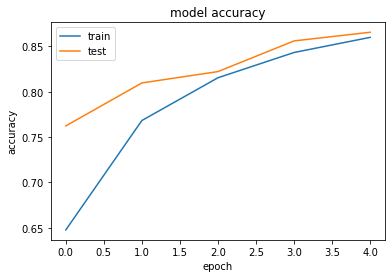

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()